In [18]:
'''
This is the third file to run where we clean the data and geth the first insights
'''

import wordcloud
import pandas as pd
import numpy as np
import re
import json
import re
from collections import Counter
import imageio
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import difflib
from tqdm import tqdm
import ast

In [4]:
#open df
df = pd.read_csv('Data/raw/comments.csv')
df1 = pd.read_csv('Data/videos.csv')

# Drop rows with missing values in the 'text' column
df.dropna(subset=['text'], inplace=True) 
 

In [11]:
def encode_text(text, encoding='utf-8'):
    encoded_text = text.encode(encoding)
    return encoded_text

def normalize_text(text):
    # Convert to lower case
    text = text.lower()
    text = text.replace(':', ' ')
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

#B
def tokenize_text(text):
    # Split text on whitespace
    tokens = re.split(r'\s+', text)
    tokens = [token for token in tokens if token.strip() != '']
    return tokens
    
#stopwords from: (adjusted by hand)
#https://github.com/stopwords-iso/stopwords-de/blob/master/stopwords-de.txt

def remove_stopwords(tokens):    
    # Read stop words from file
    with open('data/stopwords_ger.txt') as f:
        stopwords = f.read().splitlines()
    #correct encoding mistakes
    replaced_stopwords = [stopword.replace("Ã¤", "ä").replace("Ã¶", "ö").replace("Ã¼", "ü") for stopword in stopwords]
    tokens = [token for token in tokens if ':' not in token]
    # Remove stop words from list of tokens
    filtered_tokens = [token for token in tokens if token not in replaced_stopwords]

    return filtered_tokens


In [15]:
clean_tokens_list = []  # Empty list to store clean tokens
clean_text_list = []  # Empty list to store clean tokens

# Iterate over rows of dataset and apply each function
for index, row in df.iterrows():
    # Normalize text
    normalized_text = normalize_text(row['text'])
    
    # Tokenize text
    tokens = tokenize_text(normalized_text)
    
    # Remove stop words
    clean_tokens = remove_stopwords(tokens)
    
    # If you'd like to append them as one string and not as list of strings take clean_text
    clean_text = ' '.join(clean_tokens)
    
    # Append clean_tokens to the list
    clean_tokens_list.append(clean_tokens)
    
    # Append clean_text to the list
    clean_text_list.append(clean_text)

# Assign the clean_tokens_list to a new column 'clean_tokens' in the DataFrame
# Function to transform a string representation of a list into an actual list
def string_to_list(s):
    return eval(s)

# Apply the function to the "clean_tokens" column
df['clean_tokens'] = clean_tokens_list
#df["clean_tokens"] = df["clean_tokens"].apply(string_to_list)

# Assign the clean_tokens_list to a new column 'clean_tokens' in the DataFrame
df['clean_text'] = clean_text_list

In [16]:
# Create a dictionary mapping channelId to channelName
channel_mapping = {
    'UCcoQ3WG2J_Xjwwyt-sJqh-w': 'Achtung, Reichelt!',
    'UCMIgOXM2JEQ2Pv2d0_PVfcg': 'DW Deutsch',
    'UCv1WDP5EiipMQ__C4Cg6aow': 'Jung & Naiv'
}

# Add the channelName column based on the channelId matches
df['channelName'] = df['channelId'].map(channel_mapping)
df1['channelName'] = df1['videochannelId'].map(channel_mapping) 

#get rid of bot comments
df = df[~df.duplicated(subset=["text"], keep=False) & (df['clean_tokens'].str.len() > 20)]


In [17]:
'''
In this part we use regular expressions mentioned in the paper to find interactions between users 
based on @ as the youtube data api doesnt provide it 
'''
# Regex pattern to match usernames after "@"
pattern1 = r'@([\S]+)'  # Modified pattern to capture any non-whitespace characters
pattern2 = r'@(\S+\s+\S+)'

unmatched_data = []
    
# Function to process each row of the DataFrame
def process_row(row):
    text = row['text']
    #parent = row["parentID"]
    matches = re.findall(pattern1, text)
    long_match = re.findall(pattern2, text)
    
    if matches:
        replied_ids = []
        replied_names = []
        for match in matches:
            c = 0
            username = match.strip()
            for long in long_match:
                username1 = long.strip()
                #df1 = df[df["parentID"] == parent]
                match_row1 = df[df['username'].str.extract(f'({re.escape(username1)})', expand=False).notna()]
                if not match_row1.empty:
                    replied_id = match_row1.iloc[0]['authorID']
                    replied_name = match_row1.iloc[0]['username']
                    replied_ids.append(str(replied_id))
                    replied_names.append(replied_name)
                    c = 1
            #if th reges finding 2 strings doesnt match match it with 1 string, this avoids assignin false names when names have the same first 1 string. E.g. John Whick, John Sick
            if c == 0:
                match_row = df[df['username'].str.extract(f'({re.escape(username)})', expand=False).notna()]
                if not match_row.empty:
                    replied_id = match_row.iloc[0]['authorID']
                    replied_name = match_row.iloc[0]['username']
                    replied_ids.append(str(replied_id))
                    replied_names.append(replied_name)

                else:
                    unmatched_data.append({
                    'text': text,
                    'username': username
                     })
        
        if replied_ids:
            row['repliedID'] = ' '.join(replied_ids)
            row['repliedName'] = list(set(replied_names))
        else:
            row['repliedID'] = 0
            row['repliedName'] = ''

    else:
        row['repliedID'] = 0
        row['repliedName'] = ''
    
    return row


In [18]:
# Apply the processing function to each row of the DataFrame
df = df.apply(process_row, axis=1)

df["parentID"] = df["parentID"].astype(str)
df["authorID"] = df["authorID"].astype(str)

# Create a dictionary to store the counts of replies
reply_counts = {}

# Iterate over the rows to count the replies
for _, row in tqdm(df.iterrows()):
    if pd.notnull(row['repliedID']):
        for replied_id in row['repliedID'].split():
            if replied_id in reply_counts:
                reply_counts[replied_id] += 1
            else:
                reply_counts[replied_id] = 1

# Create a new column 'has_reply' in the DataFrame
df['user_replies'] = df['authorID'].map(reply_counts).fillna(0).astype(int)

df['clean_tokens'] = df['clean_tokens'].apply(ast.literal_eval)

df.to_csv("data/raw/comments.csv", index = False)
df1.to_csv("data/videos.csv", index = False)

Top 10 words of :Achtung, Reichelt!
deutschland: 10947
reichelt: 10739
grünen: 8878
regierung: 6974
land: 6296
afd: 5237
politiker: 4822
frau: 4442
politik: 4296
volk: 3766


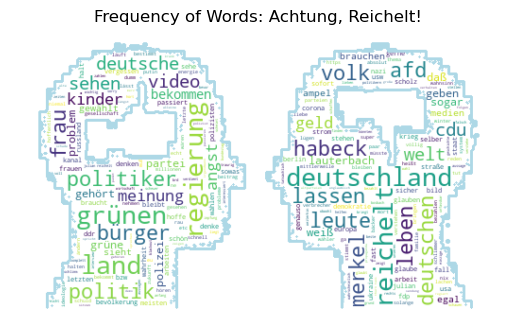

Top 10 words of :DW Deutsch
russland: 2704
ukraine: 2690
putin: 1631
krieg: 1623
deutschland: 1427
usa: 1145
nato: 987
waffen: 846
russen: 846
westen: 760


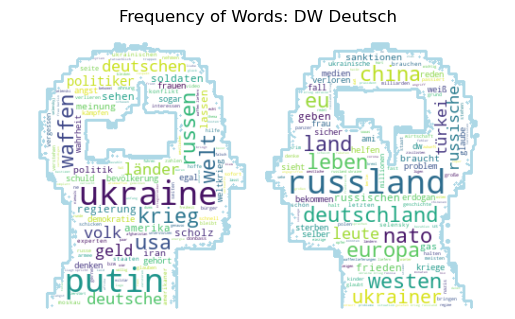

Top 10 words of :Jung & Naiv
ukraine: 705
deutschland: 524
russland: 521
hans: 502
frau: 473
interview: 457
usa: 404
krieg: 403
thema: 375
2: 360


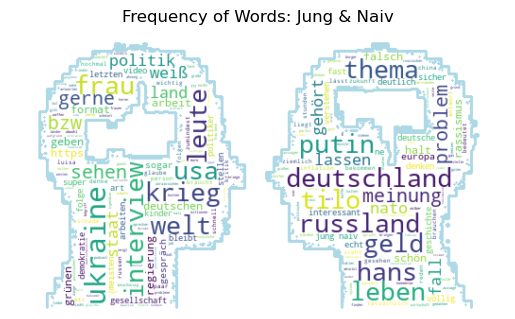

In [22]:
'''
get first insights in data and plot word cloud 
'''

mask = imageio.v2.imread('data/pol.jpg')


grouped_data = df.groupby("channelName")
all_tokens = []
for name, group in grouped_data:
    tokens = []
    # Get all tokens
    tokens.extend([token for token_list in group["clean_tokens"] for token in token_list])
    token_counts = Counter(tokens)

    all_tokens.append(tokens)
    print(f"Top 10 words of :{name}")
    for token, count in token_counts.most_common(10):
        print(f"{token}: {count}")
        
    # Create a wordcloud object for the words
    word_cloud = WordCloud(background_color='white', max_words=500, mask=mask, contour_width=3, 
                          repeat=True,
                          min_font_size=3,
                          contour_color='lightblue')
    
    word_string = ' '.join(tokens)
    
    # Generate the word wordcloud
    word_cloud.generate(word_string)
    
    # Display the word wordcloud
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Frequency of Words: {name}")
    word_cloud.to_file(f'plots/wordcloud_{name}.png')
    plt.show()
    


        
 


Top 10 words of Achtung, Reichelt!:
deutschland: 10947
reichelt: 10739
grünen: 8878
regierung: 6974
land: 6296
afd: 5237
politiker: 4822
frau: 4442
politik: 4296
volk: 3766
Top 10 words of DW Deutsch:
russland: 2704
ukraine: 2690
putin: 1631
krieg: 1623
deutschland: 1427
usa: 1145
nato: 987
waffen: 846
russen: 846
westen: 760
Top 10 words of Jung & Naiv:
ukraine: 705
deutschland: 524
russland: 521
hans: 502
frau: 473
interview: 457
usa: 404
krieg: 403
thema: 375
2: 360


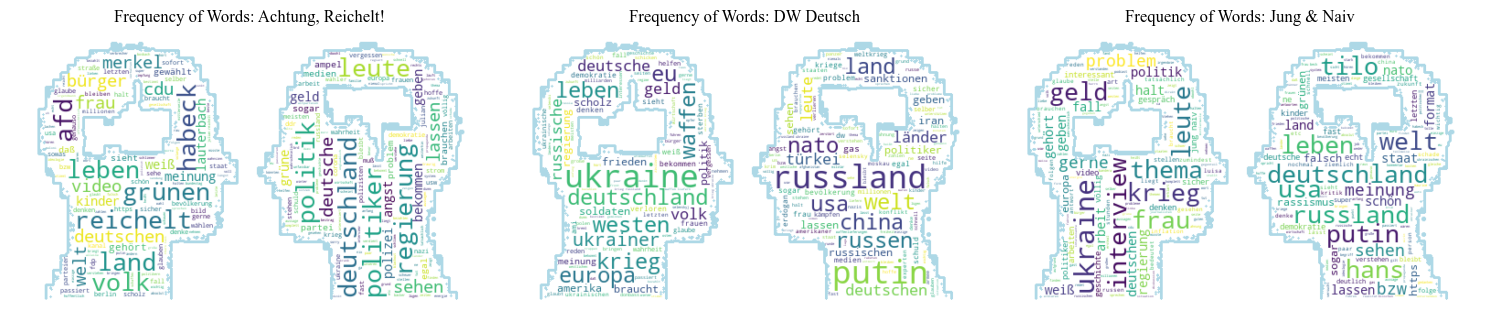

In [26]:
'''
get first insights in data and plot word cloud 
'''
df['clean_tokens'] = df['clean_tokens'].apply(ast.literal_eval)

mask = imageio.v2.imread('data/pol.jpg')


grouped_data = df.groupby("channelName")

all_wordclouds = []

for name, group in grouped_data:
    tokens = []
    tokens.extend([token for token_list in group["clean_tokens"] for token in token_list])
    token_counts = Counter(tokens)
    
    print(f"Top 10 words of {name}:")
    for token, count in token_counts.most_common(10):
        print(f"{token}: {count}")
    
    word_string = ' '.join(tokens)
    word_cloud = WordCloud(background_color='white', max_words=500, mask=mask, contour_width=3,
                           repeat=True, min_font_size=3, contour_color='lightblue')
    
    word_cloud.generate(word_string)
    all_wordclouds.append((name, word_cloud))  # Store the wordcloud for later plotting

# Plot the word clouds side by side
num_wordclouds = len(all_wordclouds)
plt.figure(figsize=(15, 5))
plt.rcParams["font.family"] = "Times New Roman"

for i, (name, word_cloud) in enumerate(all_wordclouds, 1):
    plt.subplot(1, num_wordclouds, i)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f"Frequency of Words: {name}")
    plt.axis("off")

plt.tight_layout()
plt.savefig('plots/combined_wordclouds.png')
plt.show()

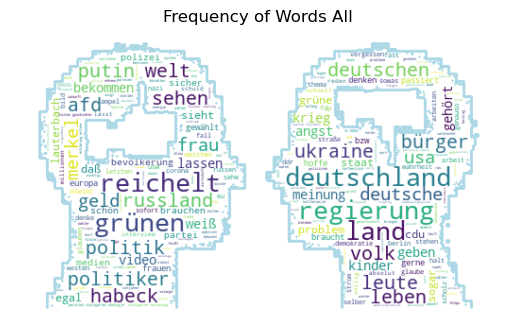

In [28]:
# Load the mask image
mask = imageio.v2.imread('data/pol.jpg')

# Create a wordcloud object for the words
word_cloud_all = WordCloud(background_color='white', max_words=500, mask=mask, contour_width=3, 
                      repeat=True,
                      min_font_size=3,
                      contour_color='lightblue')

word_string_all =' '.join(all_tokens[0]) + ' '.join(all_tokens[1]) + ' '.join(all_tokens[2]) 



# Generate the word wordcloud
word_cloud_all.generate(word_string_all)



plt.imshow(word_cloud_all, interpolation='bilinear')
plt.axis("off")
plt.title("Frequency of Words All")
plt.show()

word_cloud_all.to_file("plots/wordcloud_all.png")
